# Principal Components Echo State Networks

## Import

In [2]:
from numpy import *
from matplotlib import pyplot as plt
from scipy.sparse import rand as sprand
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs as speigs
from tqdm import trange

## Helper functions

In [3]:
def normalize_input(inputSequence):
    iMu = mean(inputSequence, axis=0)
    iMax = amax(abs(inputSequence), axis=0)
    normInputSequence = (inputSequence-iMu)/iMax
    return normInputSequence

## PC-ESN Class

In [4]:
class PCESN():
    def __init__(self,nInputUnits,nReservoirUnits,nOutputUnits,spectralRadius,sigma2,phi2):
        print('Generating PC-ESN...')
        # Structure
        self.nInputUnits = nInputUnits
        self.nReservoirUnits = nReservoirUnits
        self.nOutputUnits = nOutputUnits
        
        # Parameters
        self.spectralRadius = spectralRadius # 0<sR<1 to ensure ESP! default 0.4???
        self.sigma2 = sigma2
        self.phi2 = phi2
        self.eta = 1 # learning rate,  0.1 -> 0.01 eta^p < inf, sum(eta) = inf, 
        
        # Initalize input sum and mean variables
        self.inputMean = zeros((nInputUnits,1))
        self.inputAbs = 1*ones((nInputUnits,1)) # small enough???
        self.t = 0

        ## Initialize weights
        # H.Jaeger (Sparse reservoir weights)
        success = 0                                             
        while success == 0: # following block might fail
            try:
                self.Wres = sprand(nReservoirUnits, nReservoirUnits, density=10/nReservoirUnits)
                self.Wres = self.Wres.toarray()
                self.Wres[self.Wres!=0] -= 0.5 # modify only nonzero elements
                self.Wres = csr_matrix(self.Wres) # back to sparse
                maxVal = max(abs(speigs(A=self.Wres, k=1, which='LM')[0]))
                self.Wres /= maxVal
                success = 1
            except:
                success = 0   
        self.Wres *= self.spectralRadius
        
        self.Win = eye(nInputUnits)
        self.Wself = (2.0*random.rand(nReservoirUnits, nInputUnits)-1.0) # init not mentioned???
        self.Wfb = (2.0 * random.rand(nReservoirUnits, nOutputUnits)- 1.0)
        self.Wout = zeros((nOutputUnits,nReservoirUnits))
        self.Wdir = zeros((nOutputUnits,nInputUnits))
        self.Wtrain = hstack((self.Wout,self.Wdir)) # just a combination of [Wout Wdir]
        
        self.r = zeros((nReservoirUnits,1))
        self.s = zeros((nInputUnits,1))
        self.o = zeros((nOutputUnits,1))
        self.c = vstack((self.r, self.s))

        # Initialize covariance matrix
        self.V = self.phi2 * eye(nInputUnits + nReservoirUnits)
        
        print('Successful!\n')
        
    def train(self, inputSample,targetSample):
        """Training network on inputs with additional help of target values.

        Args:
            inputSample: numpy array (inputs x 1)
            targetSample: numpy array (inputs x 1)
        Returns:
            Updated parameters (weights and states)

        """
        
        # Normalize and center input
        self.inputMean = self.inputMean + (inputSample-self.inputMean)/(self.t+1)
        inputSample -= self.inputMean
        
        # Not used in algorithm:
        #self.inputAbs = maximum(self.inputAbs, absolute(inputSample))
        #inputSample /= self.inputAbs
        self.t += 1 # update time index

        self.s = tanh(self.Win @ inputSample) # update self-organized layer
        self.r = tanh(self.Wres @ self.r + self.Wself @ self.s + self.Wfb @ self.o)
        ccurr = self.c
        self.c = vstack((self.r, self.s))
        self.o = self.Wtrain @ self.c

        Vprev = self.V
        self.V = linalg.inv(linalg.inv(Vprev) + (1/self.sigma2) * ccurr @ ccurr.T)
        a = self.V @ linalg.inv(Vprev) @ self.Wtrain.T
        b = 1/self.sigma2 * (self.V @ ccurr) @ targetSample.T
        
        self.Wtrain = sum([a.T, b.T], axis=0)

        # Calculate GHL update 
        dWin = self.eta*(inputSample@self.s.T - tril(self.s @ self.s.T) @ self.Win)
        self.Win += dWin # update Win matrix
        
        self.eta = 1/sqrt(self.t) # Update learning rate 


## Process data

In [5]:
nInputs = 21
nOutputs = 7
split = 0.5

data = genfromtxt('Sarcos.csv', delimiter=',')
ind = round(split*data.shape[0])

uTrain = data[0:ind,0:nInputs,newaxis]
yTrain = data[0:ind,nInputs:,newaxis]
uTest = data[ind:,0:nInputs,newaxis]
yTest = data[ind:,nInputs:,newaxis]

# Normalize input
uTrain = normalize_input(uTrain)
uTest = normalize_input(uTest)


## Demo

In [6]:
nInputUnits = 21
nReservoirUnits = 600
nOutputUnits = 7
spectralRadius = 0.4
sigma2 = 0.1
phi2 = 10 # Updates every step

pcesn = PCESN(nInputUnits,nReservoirUnits,nOutputUnits,spectralRadius,sigma2,phi2)

data_len = uTrain.shape[0]
output = zeros((7,data_len,1))
test = []

totalSamples = 200

for i in trange(totalSamples): # or standard "range" to remove progress bar 
    pcesn.train(uTrain[i,:],yTrain[i,:])
    output[:,i] = pcesn.o
    

Generating PC-ESN...
Successful!



100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:20<00:00,  2.49it/s]


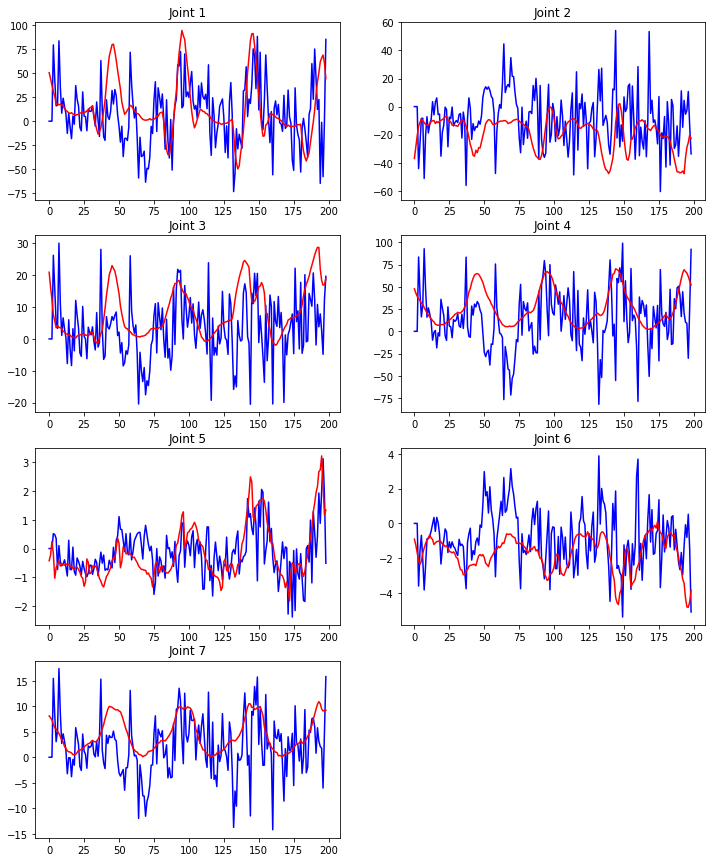

In [13]:
plt.figure(figsize=(12,15))
for j in range(1,8):
    plt.subplot(420+j)
    plt.plot(output[j-1,0:199],'b')
    plt.plot(yTrain[0:199,j-1],'r')
    plt.title('Joint {}'.format(j))

## Useless(?) stuff

In [ ]:
# Init
self.noiseLevel = 0.0
self.leakingRate = 1
self.forgetPoints = 100
self.reg = 1e-5 # If ridge regression!!! (something else than 1)

self.RLS_lambda = 0.9999995
self.RLS_delta = 0.000001

self.trained = 0
self.pseudo = True

# init default
self.inputScaling = ones((nInputUnits, 1)) # MAKE SURE INPUT IS NORMALIZED!!!
self.inputShift = zeros((nInputUnits, 1))
self.teacherScaling = ones((nOutputUnits, 1)) # DOES TEACHER SCALING MAKE ANY DIFFERENCE???
self.teacherShift = zeros((nOutputUnits, 1))
self.teacherForcing = True # Desired output y_teacher instead of predicted y -> Ridge regression!!!  
self.feedbackScaling = zeros((nOutputUnits, 1))

self.s = zeros((nInputUnits,1))
self.o = zeros((nOutputUnits,1))
self.c = vstack((self.r, self.s))

In [ ]:
m = array([[1,0,0],[0,5,6],[7,8,0]])
c = array([[1],[2],[3]])
k=csr_matrix(m).multiply(csr_matrix(c)).todense()


A=array([[1,1,1],[2,2,2],[3,3,3]])

print(var(uTrain,axis=0).shape)